### Baseline Models

In this notebook, we create several simple baseline models for saturation.

In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn
import statsmodels.api as sm
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

from typing import List, Tuple, Dict

In [141]:
def report_model(model, X_score: np.ndarray, y_true: np.array):
    # Score the model
    y_pred_proba = model.predict_proba(X_score)[:, 1]
    y_pred = np.where(y_pred_proba < 0.5, False, True)

    # Print a few metrics
    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    
    if y_pred_proba is not None:
        roc_auc = metrics.roc_auc_score(y_true, y_pred_proba)
    else:
        roc_auc = "NA"
        
    print(f"Accuracy={accuracy:.3f}, F1={f1_score:.3f}, ROC AUC={roc_auc:.3f}")
    
    # Confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.show()
    
    # Plot ROC curve if applicable
    if y_pred_proba is not None:
        fpr, tpr, _ = metrics.roc_curve(y_true, y_pred_proba)
        plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}", color="darkorange")
        plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc="lower right")
        plt.show()
        
    # Report feature importances if available
    if hasattr(model, "feature_importances_"):
        print("Feature importances:")
        
        importances = list(zip(X_score.columns, model.feature_importances_))
        importances = sorted(importances, key=lambda x: -x[1])
        for feature, importance in importances:
            print(f"    {feature}: {importance:.3f}")

In [232]:
def load_data_using_lookup(saturation_points: Dict[str, int]) -> pd.DataFrame:
    data = []

    for path, saturation_point in saturation_points.items():
        df = pd.read_csv(f"{path}/statistics.csv")
        df["path"] = path
        df = df.rename(columns={
            'n_craters_added_in_observed_area': 'n_craters_added_in_study_region',
            'n_craters_in_observed_area': 'n_craters_in_study_region'})

        df["is_saturated"] = df.n_craters_added_in_study_region >= saturation_point

        data.append(df)

    data = pd.concat(data, axis=0)
    data = data.dropna().reset_index(drop=True)
    
    return data

In [234]:
# Create a dictionary of data paths to their saturation points
base_path = "/home/mason/full_runs/python/manual_labeled_runs/1.00_3.00_0.40_1.50"
saturation_points = {
    f"{base_path}/1": 2500,
    f"{base_path}/2": 1700,
    f"{base_path}/3": 2000,
    f"{base_path}/4": 1200,
    f"{base_path}/5": 2000,
    f"{base_path}/6": 1100,
    f"{base_path}/7": 800,
    f"{base_path}/8": 900,
    f"{base_path}/9": 1800,
    f"{base_path}/10": 700
}

In [235]:
data = load_data_using_lookup(saturation_points)

In [236]:
data

,crater_id,n_craters_added_in_study_region,n_craters_in_study_region,areal_density,z,za,path,is_saturated
0,8,2,2,0.000007,1.589071,1.589086,/home/mason/full_runs/python/manual_labeled_ru...,False
1,21,3,4,0.000011,-0.403078,-0.403059,/home/mason/full_runs/python/manual_labeled_ru...,False
2,22,4,4,0.000011,-0.403078,-0.403059,/home/mason/full_runs/python/manual_labeled_ru...,False
3,24,5,5,0.000073,-1.393156,-1.393051,/home/mason/full_runs/python/manual_labeled_ru...,False
4,28,6,6,0.000087,-0.709373,-0.709199,/home/mason/full_runs/python/manual_labeled_ru...,False
...,...,...,...,...,...,...,...,...
49984,23645,4996,1298,0.334492,-3.841010,10.855310,/home/mason/full_runs/python/manual_labeled_ru...,True
49985,23653,4997,1299,0.334493,-3.814762,10.893589,/home/mason/full_runs/python/manual_labeled_ru...,True
49986,23661,4998,1300,0.334495,-3.790249,10.929747,/home/mason/full_runs/python/manual_labeled_ru...,True
49987,23674,4999,1302,0.334500,-3.784426,10.949132,/home/mason/full_runs/python/manual_labeled_ru...,True


In [79]:
# Note the imbalance
data.is_saturated.mean()

0.7063553981876013

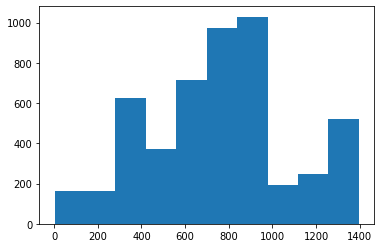

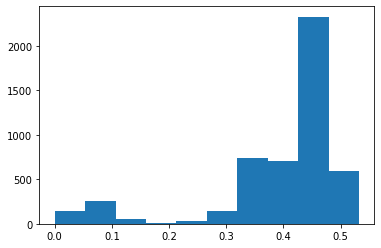

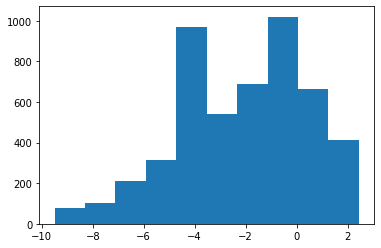

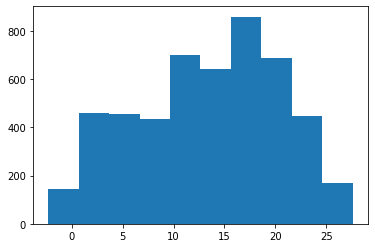

In [294]:
plt.hist(data.n_craters_in_study_region)
plt.show()

plt.hist(data.areal_density)
plt.show()

plt.hist(data.z)
plt.show()

plt.hist(data.za)
plt.show()

In [ ]:
X = data[["n_craters_in_study_region", "areal_density", "z", "za"]]
y = data.is_saturated

### Naive model: use Za > 1.96

Accuracy=0.507, F1=0.665, ROC AUC=0.622


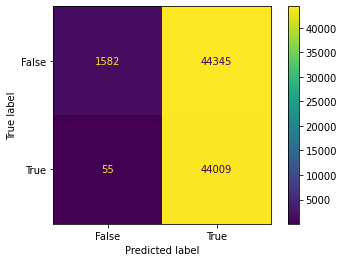

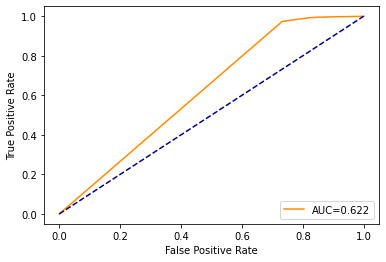

In [292]:
class ZaModel:
    def predict_proba(self, X) -> np.array:
        positive = 1 - stats.norm.sf(X.za)
        return np.vstack([1 - positive, positive]).T
    
report_model(ZaModel(), X_test, y_test)

In [295]:
X_test.za > 1.96

282252     True
180157     True
97339      True
422174     True
1905       True
          ...  
445508     True
132896    False
286118     True
6513       True
187029     True
Name: za, Length: 89991, dtype: bool

### Create a simple logistic regression model

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model = LogisticRegression(random_state=42).fit(X_train, y_train)

Accuracy=0.907, F1=0.937, ROC AUC=0.922


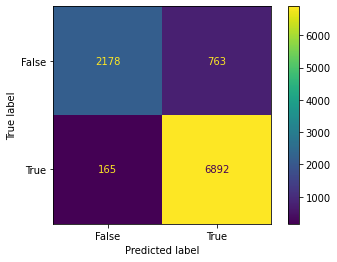

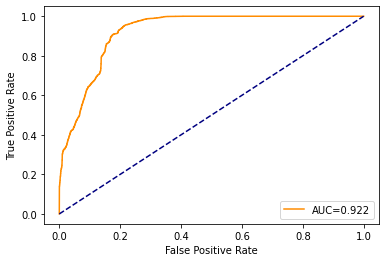

In [132]:
report_model(model, X_test, y_test)

In [158]:
# Using statsmodels instead
# sklearn does not provide p-values
model = sm.Logit(y_train, X_train)
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.370750
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           is_saturated   No. Observations:                39991
Model:                          Logit   Df Residuals:                    39987
Method:                           MLE   Df Model:                            3
Date:                Mon, 17 Oct 2022   Pseudo R-squ.:                  0.3875
Time:                        19:42:08   Log-Likelihood:                -14827.
converged:                       True   LL-Null:                       -24205.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
n_craters_in_study_region    -0.0033   6.85e-05    -47.971      0.000      -0.003      -0.003
areal_density               -11.6647      0.257    -45.407      0.000     -12.168     -11.161
z                            -0.8898      0.012    -71.302      0.000      -0.914      -0.865
za                            0.5104      0.007     71.999      0.000       0.496       0.524
=============================================================================================
"""

### Create a simple linear discriminant analysis model
- Assumptions:
  - All independent variables are continuous and follow a normal distribution

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model = LinearDiscriminantAnalysis().fit(X_train, y_train)

Accuracy=0.899, F1=0.933, ROC AUC=0.913


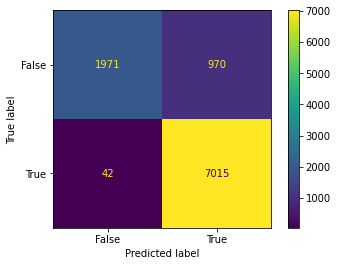

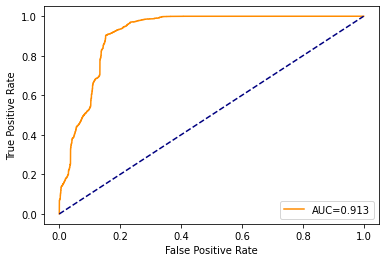

In [134]:
report_model(model, X_test, y_test)

### Create a random forest classifier model

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model = RandomForestClassifier(max_depth=3,
                               n_estimators=1000,
                               n_jobs=10,
                               random_state=42).fit(X_train, y_train)

Accuracy=0.920, F1=0.945, ROC AUC=0.939


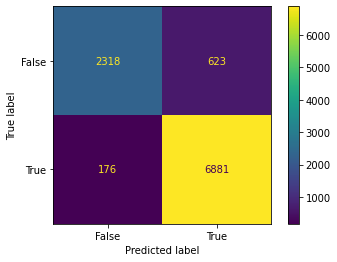

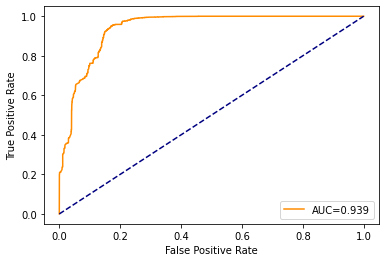

Feature importances:
    areal_density: 0.650
    za: 0.206
    n_craters_in_study_region: 0.089
    z: 0.055


In [153]:
report_model(model, X_test, y_test)

### Create a gradient boosting classifier model

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model = GradientBoostingClassifier(max_depth=3,
                                   n_estimators=1000,
                                   random_state=42).fit(X_train, y_train)

Accuracy=0.997, F1=0.998, ROC AUC=1.000


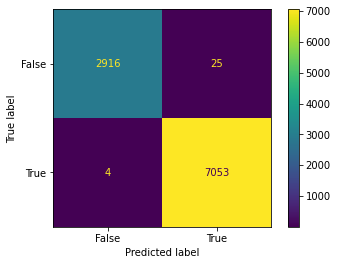

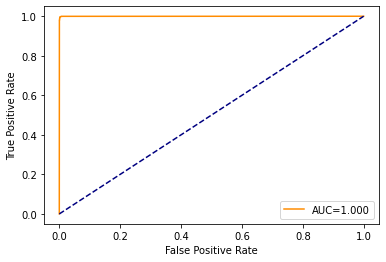

Feature importances:
    areal_density: 0.855
    n_craters_in_study_region: 0.059
    z: 0.058
    za: 0.028


In [147]:
report_model(model, X_test, y_test)

In [ ]:
X_test["gbm_pred"] = np.where(model.predict_proba(X_test)[:,0] > 0.5, False, True)

In [52]:
X_test["actual"] = y_test

In [53]:
X_test

,n_craters_in_study_region,areal_density,z,za,gbm_pred,actual
38277,817,0.459530,-7.638674,9.307914,True,True
44871,548,0.488548,-2.173519,14.797773,True,True
34656,1043,0.614128,-5.354489,29.057364,True,True
39175,933,0.549749,-2.012450,25.651205,True,True
20253,250,0.032371,-0.678556,-0.188008,False,False
...,...,...,...,...,...,...
39069,865,0.532507,-3.122988,21.458170,True,True
34649,1041,0.610761,-5.648473,28.156593,True,True
46553,809,0.479322,2.312950,24.200594,True,True
16386,701,0.395917,-0.874678,13.392478,True,True


### Using more simulation parameter sets

In [296]:
# Create a dictionary of data paths to their saturation points
base_path1 = "/home/mason/full_runs/python/manual_labeled_runs/1.00_3.00_0.40_1.50"
base_path2 = "/home/mason/full_runs/python/manual_labeled_runs/1.25_3.00_0.60_1.10"
base_path3 = "/home/mason/full_runs/python/manual_labeled_runs/1.50_5.00_0.60_1.10"
base_path4 = "/home/mason/full_runs/python/manual_labeled_runs/2.00_5.00_0.60_1.90"
saturation_points = {
    f"{base_path1}/1": 2500,
    f"{base_path1}/2": 1700,
    f"{base_path1}/3": 2000,
    f"{base_path1}/4": 1200,
    f"{base_path1}/5": 2000,
    f"{base_path1}/6": 1100,
    f"{base_path1}/7": 800,
    f"{base_path1}/8": 900,
    f"{base_path1}/9": 1800,
    f"{base_path1}/10": 700,
    
    f"{base_path2}/1": 6500,
    f"{base_path2}/2": 4000,
    f"{base_path2}/3": 4500,
    f"{base_path2}/4": 5000,
    f"{base_path2}/5": 3200,
    f"{base_path2}/6": 3300,
    f"{base_path2}/7": 4100,
    f"{base_path2}/8": 3100,
    f"{base_path2}/9": 4200,
    f"{base_path2}/10": 3200,
    
    f"{base_path3}/1": 5400,
    f"{base_path3}/2": 7000,
    f"{base_path3}/3": 4500,
    f"{base_path3}/4": 3200,
    f"{base_path3}/5": 3600,
    f"{base_path3}/6": 4800,
    f"{base_path3}/7": 3100,
    f"{base_path3}/8": 6000,
    f"{base_path3}/9": 3100,
    f"{base_path3}/10": 6900,
    
    f"{base_path4}/1": 8500,
    f"{base_path4}/2": 17500,
    f"{base_path4}/3": 12500,
    f"{base_path4}/4": 9500,
    f"{base_path4}/5": 12000,
    f"{base_path4}/6": 15000,
    f"{base_path4}/7": 15000,
    f"{base_path4}/8": 13000,
    f"{base_path4}/9": 12500,
    f"{base_path4}/10": 12500,

}

In [297]:
data = []

for path, saturation_point in saturation_points.items():
    df = pd.read_csv(f"{path}/statistics.csv")
    df["path"] = path
    df = df.rename(columns={
        'n_craters_added_in_observed_area': 'n_craters_added_in_study_region',
        'n_craters_in_observed_area': 'n_craters_in_study_region'})
    
    df["is_saturated"] = df.n_craters_added_in_study_region >= saturation_point
    
    data.append(df)

data = pd.concat(data, axis=0)
data = data.dropna().reset_index(drop=True)

In [298]:
# Note the imbalance
data.is_saturated.mean()

0.4859163381145628

In [299]:
X = data[["n_craters_in_study_region", "areal_density", "z", "za"]]
y = data.is_saturated

### Logit model

In [300]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model = LogisticRegression(random_state=42).fit(X_train, y_train)

Accuracy=0.756, F1=0.761, ROC AUC=0.827


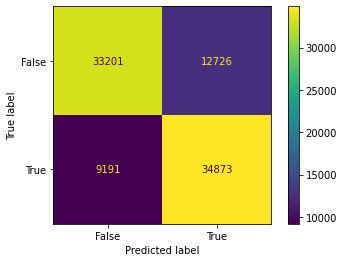

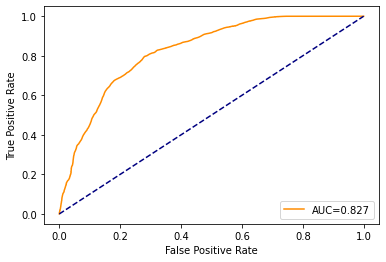

In [301]:
report_model(model, X_test, y_test)

In [302]:
# Using statsmodels instead
# sklearn does not provide p-values
model = sm.Logit(y_train, X_train)
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.620660
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           is_saturated   No. Observations:               359963
Model:                          Logit   Df Residuals:                   359959
Method:                           MLE   Df Model:                            3
Date:                Wed, 19 Oct 2022   Pseudo R-squ.:                  0.1040
Time:                        14:50:52   Log-Likelihood:            -2.2341e+05
converged:                       True   LL-Null:                   -2.4934e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
n_craters_in_study_region    -0.0003   5.01e-06    -53.295      0.000      -0.000      -0.000
areal_density                -5.7711      0.047   -122.143      0.000      -5.864      -5.678
z                            -0.1417      0.001    -96.989      0.000      -0.145      -0.139
za                            0.1291      0.001    168.429      0.000       0.128       0.131
=============================================================================================
"""

### Linear discriminant analysis model

In [303]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model = LinearDiscriminantAnalysis().fit(X_train, y_train)

Accuracy=0.782, F1=0.805, ROC AUC=0.860


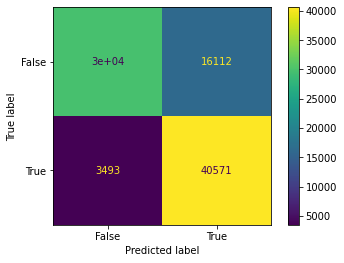

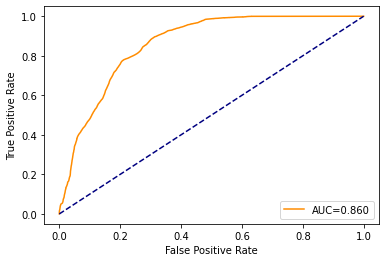

In [304]:
report_model(model, X_test, y_test)

### Random forest model

In [305]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model = RandomForestClassifier(max_depth=3,
                               n_estimators=1000,
                               n_jobs=10,
                               random_state=42).fit(X_train, y_train)

Accuracy=0.809, F1=0.803, ROC AUC=0.897


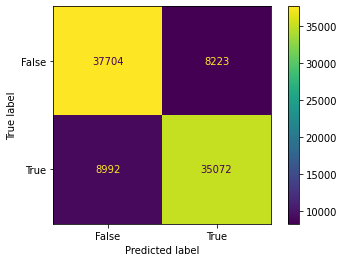

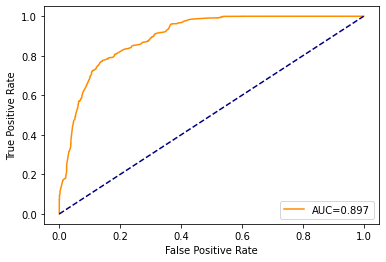

Feature importances:
    areal_density: 0.598
    za: 0.214
    n_craters_in_study_region: 0.129
    z: 0.059


In [306]:
report_model(model, X_test, y_test)

### Gradient boosted tree classifier

In [307]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model = GradientBoostingClassifier(max_depth=3,
                                   n_estimators=1000,
                                   random_state=42).fit(X_train, y_train)

Accuracy=0.950, F1=0.949, ROC AUC=0.992


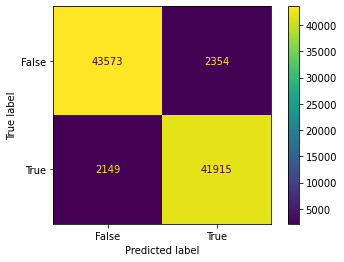

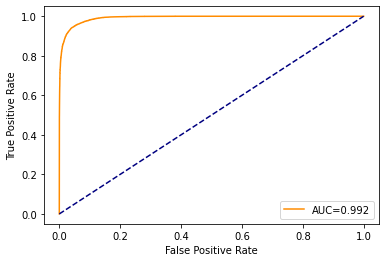

Feature importances:
    areal_density: 0.621
    n_craters_in_study_region: 0.236
    z: 0.091
    za: 0.053


In [308]:
report_model(model, X_test, y_test)

### Plotting actual vs predicted probability

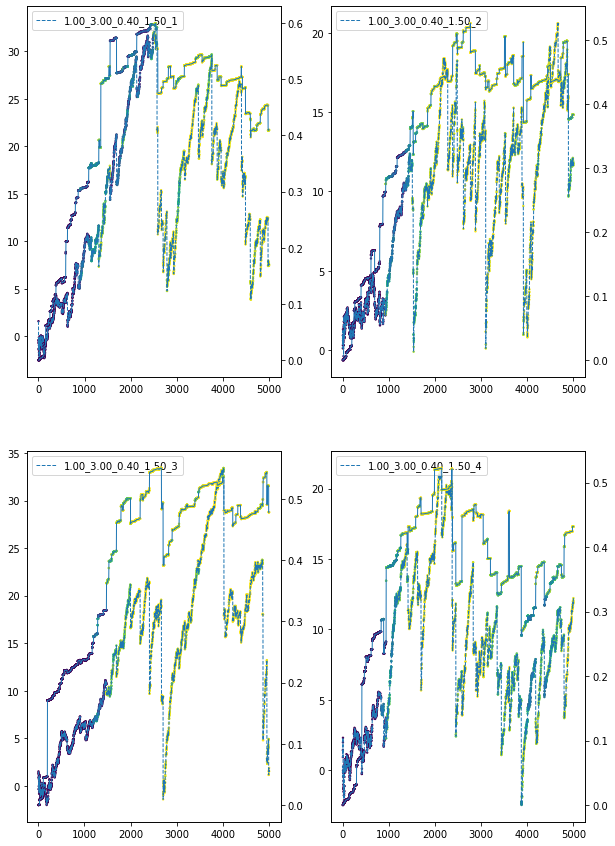

In [374]:
n_rows = 2
n_cols = 2
start_item = 0
n_items = n_rows * n_cols
metric1 = "za"
metric2 = "areal_density"

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5*n_rows, 15))
plot_counter = 0

for x in [x for x in saturation_points.items()][start_item:start_item + n_items]:
    ax_row = plot_counter // n_cols
    ax_col = plot_counter % n_cols
    ax = axes[ax_row][ax_col]
        
    data = load_data_using_lookup(dict([x]))

    X = data[["n_craters_in_study_region", "areal_density", "z", "za"]]
    data["y_pred_proba"] = model.predict_proba(X)[:, 1]
    data["y_pred"] = np.where(data.y_pred_proba < 0.5, False, True)

    # Bluer = higher probability of not saturated
    # Yellower = higher probability of saturated
    ax.plot(data.n_craters_added_in_study_region, data[metric1], lw=1, ls='--')
    ax.scatter(data.n_craters_added_in_study_region, data[metric1], s=2, c=data.y_pred_proba)
    
    ax2 = ax.twinx()
    ax2.plot(data.n_craters_added_in_study_region, data[metric2], lw=1)
    ax2.scatter(data.n_craters_added_in_study_region, data[metric2], s=2, c=data.y_pred_proba)
    ax.legend(["_".join(x[0].split("/")[-2:])], loc="upper left")
    
    plot_counter += 1

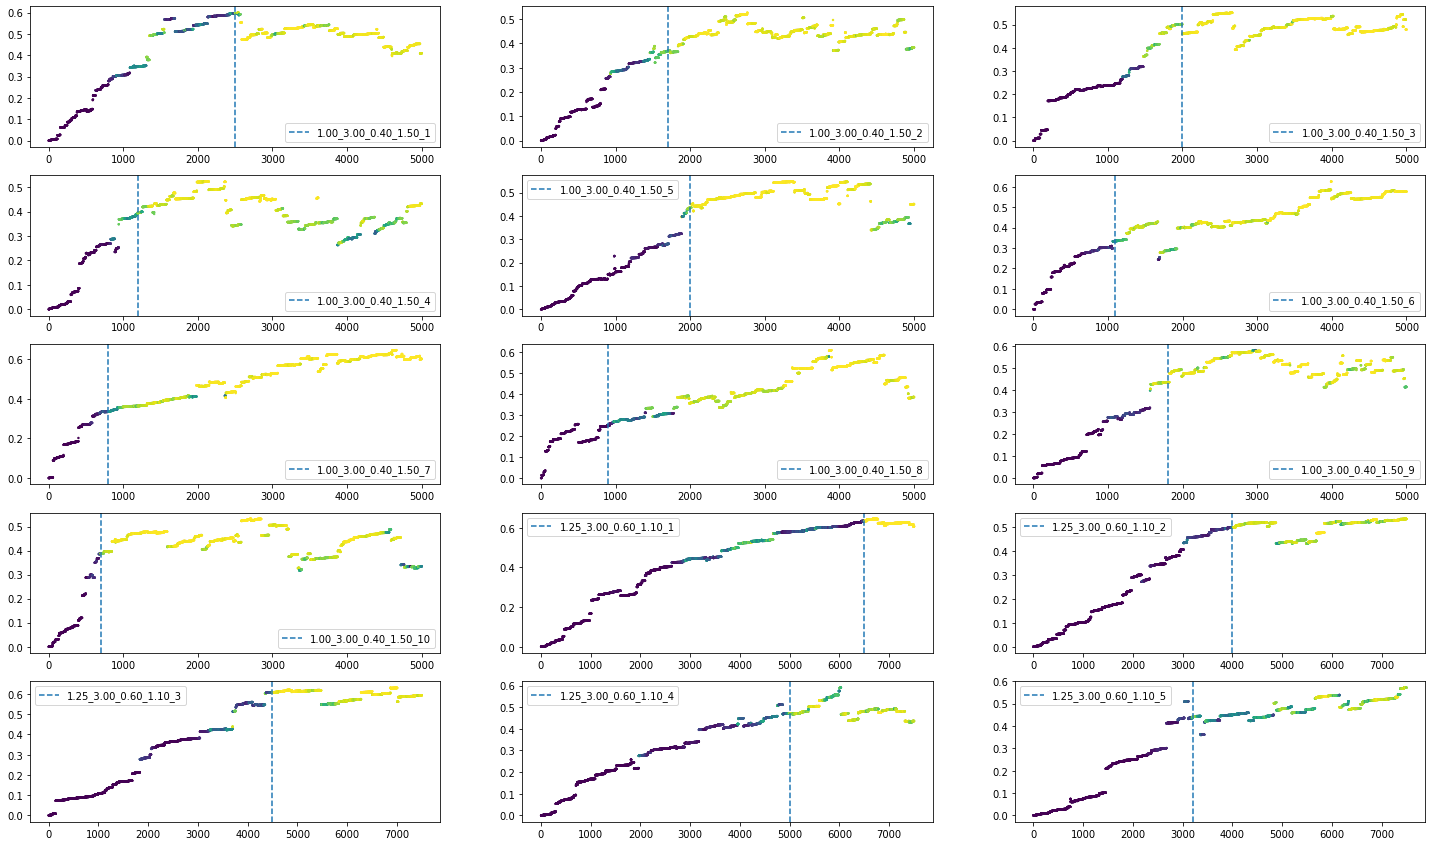

In [346]:
n_rows = 5
n_cols = 3
start_item = 0
n_items = n_rows * n_cols
metric = "areal_density"

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(25, 15))
plot_counter = 0

for x in [x for x in saturation_points.items()][start_item:start_item + n_items]:
    ax_row = plot_counter // n_cols
    ax_col = plot_counter % n_cols
    ax = axes[ax_row][ax_col]
        
    data = load_data_using_lookup(dict([x]))

    X = data[["n_craters_in_study_region", "areal_density", "z", "za"]]
    data["y_pred_proba"] = model.predict_proba(X)[:, 1]
    data["y_pred"] = np.where(data.y_pred_proba < 0.5, False, True)

    # Bluer = higher probability of not saturated
    # Yellower = higher probability of saturated
    # plt.plot(data.n_craters_added_in_study_region, data.n_craters_in_study_region, lw=1)
    ax.axvline(x=x[1], ls="--")
    ax.scatter(data.n_craters_added_in_study_region, data[metric], s=2, c=data.y_pred_proba)
    ax.legend(["_".join(x[0].split("/")[-2:])])
    
    plot_counter += 1

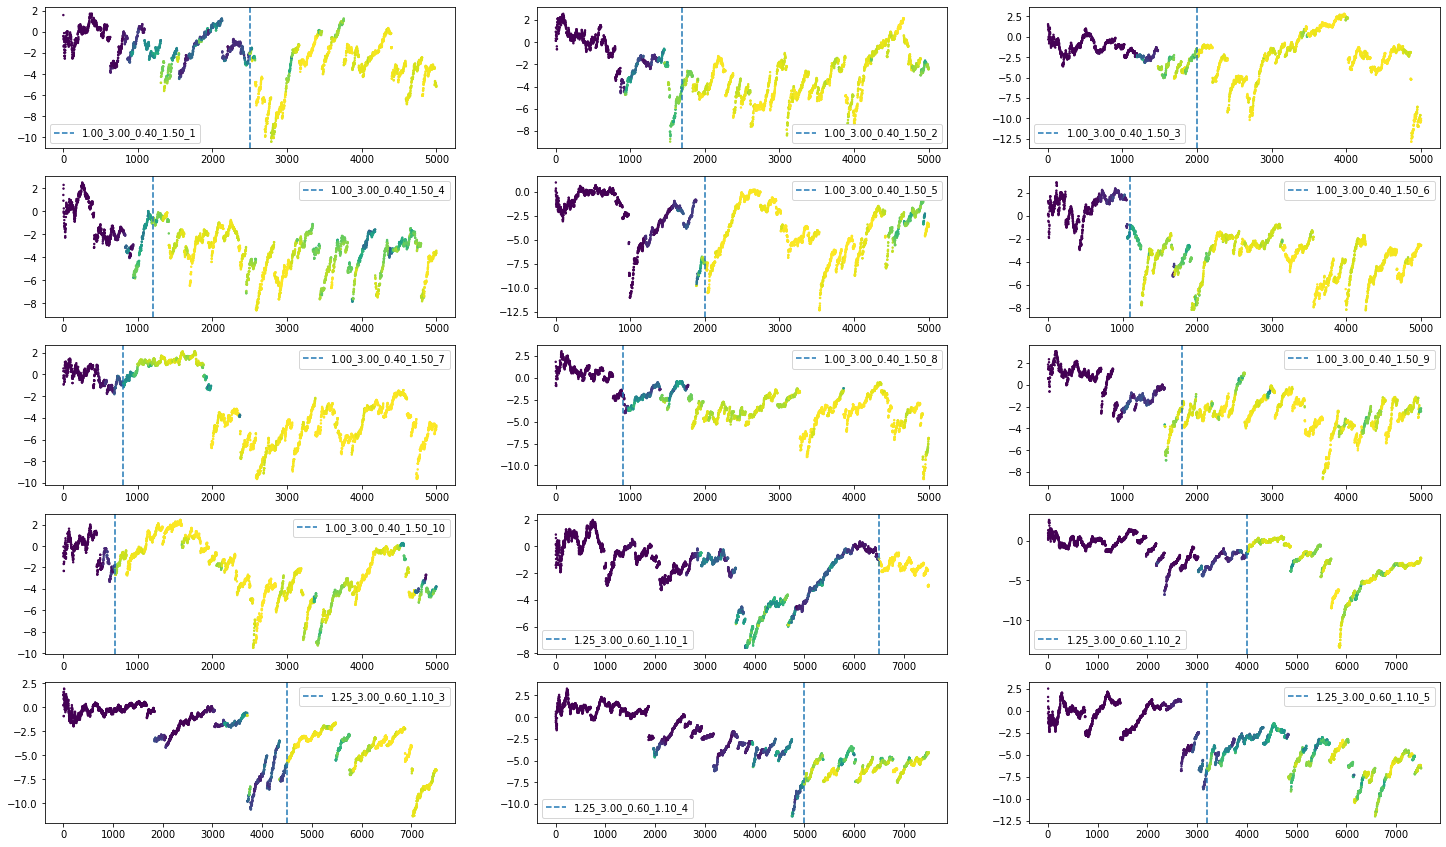

In [347]:
n_rows = 5
n_cols = 3
start_item = 0
n_items = n_rows * n_cols
metric = "z"

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(25, 15))
plot_counter = 0

for x in [x for x in saturation_points.items()][start_item:start_item + n_items]:
    ax_row = plot_counter // n_cols
    ax_col = plot_counter % n_cols
    ax = axes[ax_row][ax_col]
        
    data = load_data_using_lookup(dict([x]))

    X = data[["n_craters_in_study_region", "areal_density", "z", "za"]]
    data["y_pred_proba"] = model.predict_proba(X)[:, 1]
    data["y_pred"] = np.where(data.y_pred_proba < 0.5, False, True)

    # Bluer = higher probability of not saturated
    # Yellower = higher probability of saturated
    # plt.plot(data.n_craters_added_in_study_region, data.n_craters_in_study_region, lw=1)
    ax.axvline(x=x[1], ls="--")
    ax.scatter(data.n_craters_added_in_study_region, data[metric], s=2, c=data.y_pred_proba)
    ax.legend(["_".join(x[0].split("/")[-2:])])
    
    plot_counter += 1

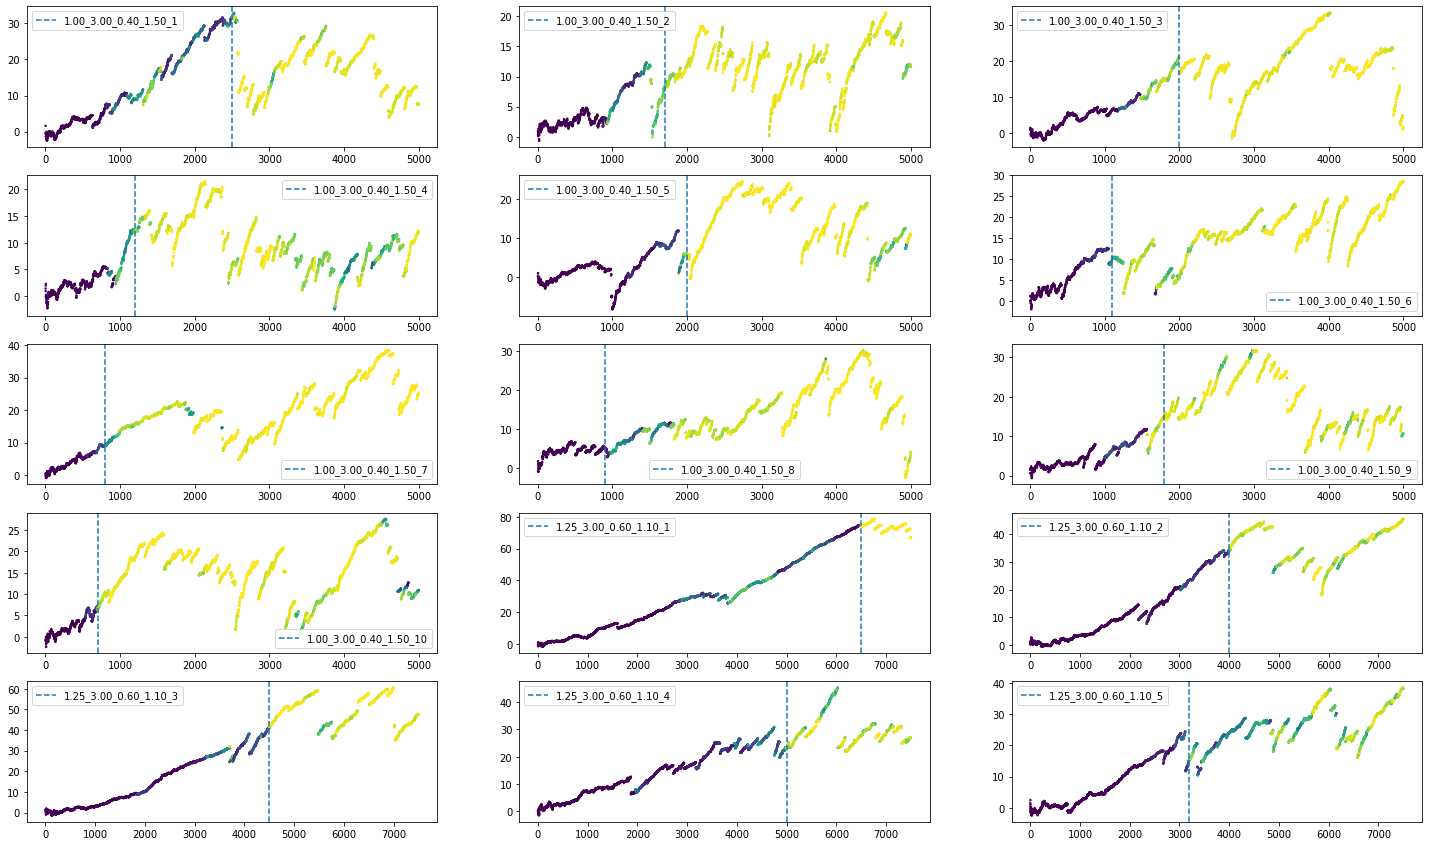

In [348]:
n_rows = 5
n_cols = 3
start_item = 0
n_items = n_rows * n_cols
metric = "za"

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(25, 15))
plot_counter = 0

for x in [x for x in saturation_points.items()][start_item:start_item + n_items]:
    ax_row = plot_counter // n_cols
    ax_col = plot_counter % n_cols
    ax = axes[ax_row][ax_col]
        
    data = load_data_using_lookup(dict([x]))

    X = data[["n_craters_in_study_region", "areal_density", "z", "za"]]
    data["y_pred_proba"] = model.predict_proba(X)[:, 1]
    data["y_pred"] = np.where(data.y_pred_proba < 0.5, False, True)

    # Bluer = higher probability of not saturated
    # Yellower = higher probability of saturated
    # plt.plot(data.n_craters_added_in_study_region, data.n_craters_in_study_region, lw=1)
    ax.axvline(x=x[1], ls="--")
    ax.scatter(data.n_craters_added_in_study_region, data[metric], s=2, c=data.y_pred_proba)
    ax.legend(["_".join(x[0].split("/")[-2:])])
    
    plot_counter += 1